In [40]:
import random
import numpy as np

import initialization
import evaluation
import parent_selection
import crossover
import survivor_selection
import environment
import mutation

In [41]:
def bins_ea(bin_info, pop_size=24, mating_pool_size=8, tournament_size=4, crossover_rate=0, mut_rate=0.3, max_gen=1000, target=25, rng=True):

    if(rng == False):
        random.seed()

    bin_count = len(bin_info.bins)
    avg_dist = []

    # Initialization
    population = initialization.pop_init(pop_size, bin_info, bin_count)
    fitness = [] # Fitness ranges from 0 to bin_count
    for i in population:
        fitness.append(evaluation.fitness(i, bin_info))
    gen = 0
    og_fitness = fitness.copy()
    # Main Evolutionary Loop
    while (gen < max_gen and max(fitness) < target):

        parents = parent_selection.tournament_select(population, fitness, mating_pool_size, tournament_size)
        random.shuffle(parents)
        offspring = []
        offspring_fitness = []
        
        i=0
        while len(offspring) < mating_pool_size:
            # Generates 2 new offspring using PMX
            off = crossover.crossover_main(population[parents[i]], population[parents[i+1]], crossover_rate)
            # Performs inversion mutation on offspring
            off1 = mutation.inv_mut(off[0],mut_rate)
            off2 = mutation.inv_mut(off[1],mut_rate)
            offspring.append(off1)
            offspring.append(off2)
            offspring_fitness.append(evaluation.fitness(off1,bin_info))
            offspring_fitness.append(evaluation.fitness(off2,bin_info))
            i += 2
        population, fitness = survivor_selection.mu_plus_lambda(population, fitness, offspring, offspring_fitness)
        print("gen: ",gen," - max fit: ",max(fitness)," - pop size: ", len(population))
        avg_dist.append(len(population[0]) / (sum(fitness)/len(fitness)))
        gen += 1
    return population, fitness, og_fitness, gen, avg_dist

In [42]:
bin_info = environment.BinInfo('../datasets/BinLocations.csv', '../datasets/BinDistances.csv')
pop_size = 200
mating_pool_size = 60 # Must be even
tournament_size = 40
crossover_rate = 0
mut_rate = 0.6
max_gen = 100000
target_fitness = 8

gen_count = 0
population, fitness, fitness_o, gen_count, avg_dist = bins_ea(bin_info, pop_size, mating_pool_size, tournament_size, crossover_rate, mut_rate, max_gen, target_fitness, True)
route = population[fitness.index(max(fitness))]

gen:  0  - max fit:  1.0566115818633723  - pop size:  200
gen:  1  - max fit:  1.0579601451189302  - pop size:  200
gen:  2  - max fit:  1.0583012771462657  - pop size:  200
gen:  3  - max fit:  1.0583012771462657  - pop size:  200
gen:  4  - max fit:  1.0583012771462657  - pop size:  200
gen:  5  - max fit:  1.0583012771462659  - pop size:  200
gen:  6  - max fit:  1.0592542442418276  - pop size:  200
gen:  7  - max fit:  1.0593978041018015  - pop size:  200
gen:  8  - max fit:  1.0594668451102045  - pop size:  200
gen:  9  - max fit:  1.0596500446910402  - pop size:  200
gen:  10  - max fit:  1.060528276490818  - pop size:  200
gen:  11  - max fit:  1.0620638715930037  - pop size:  200
gen:  12  - max fit:  1.0620638715930037  - pop size:  200
gen:  13  - max fit:  1.062521646674275  - pop size:  200
gen:  14  - max fit:  1.0627559399473492  - pop size:  200
gen:  15  - max fit:  1.0632377468091645  - pop size:  200
gen:  16  - max fit:  1.063830104358424  - pop size:  200
gen:  17  

#### Evolutionary Algorithm Summary

Best Individual: [242, 223, 77, 8, 80, 82, 11, 38, 65, 17, 26, 230, 149, 136, 109, 172, 161, 174, 93, 103, 90, 186, 144, 134, 132, 96, 157, 183, 188, 159, 118, 110, 169, 104, 164, 138, 190, 162, 131, 126, 120, 145, 171, 97, 296, 279, 300, 278, 293, 294, 271, 128, 238, 228, 229, 239, 222, 235, 233, 250, 240, 243, 249, 221, 66, 72, 21, 247, 236, 225, 226, 241, 217, 213, 248, 203, 211, 220, 255, 253, 309, 264, 297, 286, 269, 284, 258, 310, 307, 305, 292, 259, 182, 176, 173, 124, 146, 122, 91, 170, 196, 175, 140, 154, 153, 187, 141, 129, 151, 158, 189, 184, 99, 119, 135, 199, 142, 95, 19, 168, 117, 133, 92, 112, 152, 94, 177, 180, 192, 101, 123, 178, 166, 150, 160, 163, 137, 143, 191, 106, 114, 260, 194, 107, 185, 116, 98, 301, 25, 43, 48, 76, 63, 273, 288, 295, 274, 290, 272, 308, 275, 270, 262, 291, 304, 277, 267, 276, 302, 285, 257, 283, 60, 32, 18, 50, 79, 7, 27, 45, 73, 22, 71, 67, 2, 55, 31, 52, 44, 24, 85, 9, 69, 4, 41, 87, 75, 29, 59, 64, 56, 15, 30, 16, 84, 61, 39, 53, 37, 58, 89,

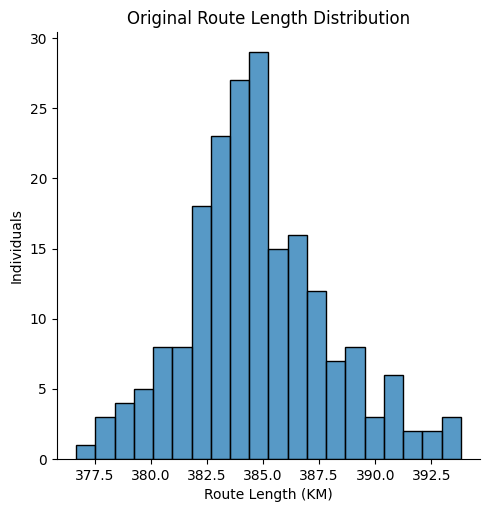

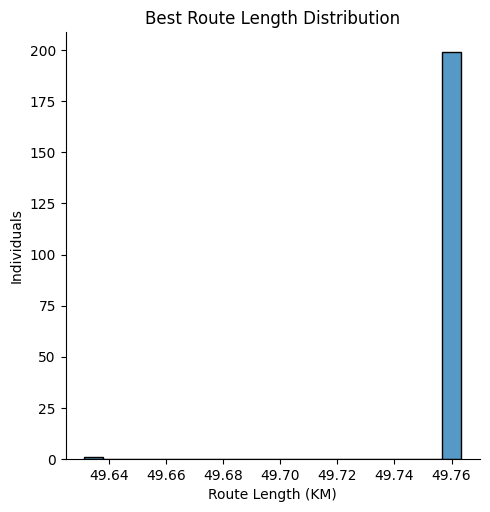

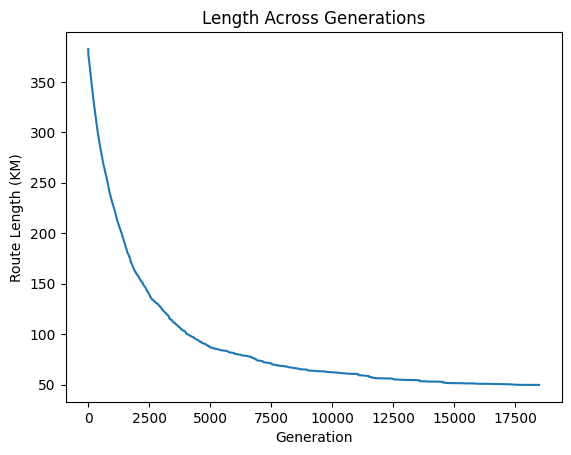

In [43]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

print("Best Individual:", route)
print("Best Fitness:", evaluation.fitness(route, bin_info), "    Target Fitness:", target_fitness)
print("Best Route Length:", round(len(route)/evaluation.fitness(route, bin_info),2),"KM\n")

fitness_increase = ((sum(fitness) - sum(fitness_o)) / sum(fitness_o))/gen_count
print("Average Improvement Per Generation:",round(fitness_increase*100,2),"% Fitness Increase")
print("Generations to Terminate:", gen_count)
print("Max Generations Allowed", max_gen, "\n")

count = 0
for i in range(len(route)-1):
    if(bin_info.get_dist(route[i], route[i+1]) == 1):
        count += 1
print("\'Bad\' Paths:", count)

len_map = pd.DataFrame({"Route Length": [len(route)/f for f in fitness]})
len_map_o = pd.DataFrame({"Route Length": [len(route)/f for f in fitness_o]})
dist_map = pd.DataFrame({"length": avg_dist})

plt1=sb.displot(len_map_o,x="Route Length",bins=20).set(title="Original Route Length Distribution", xlabel='Route Length (KM)', ylabel="Individuals")
plt.show()
plt2=sb.displot(len_map,x="Route Length",bins=20).set(title="Best Route Length Distribution", xlabel='Route Length (KM)', ylabel="Individuals")
plt.show()
plt3=sb.lineplot(x=dist_map.index, y='length', data=dist_map).set(title="Length Across Generations", xlabel='Generation', ylabel="Route Length (KM)")
plt.show()

#### SHAP Results

In [44]:
import shap

bin_data = pd.DataFrame(bin_info.bins, columns=bin_info.headers)
X = np.asarray(bin_info.bins)
X = X[:,-2:]
explainer = shap.PermutationExplainer(route,X)
shap_vals = explainer(X[:100])
shap.summary_plot(shap_values=shap_vals, features=route, plot_type='bar')

TypeError: The DType <class 'numpy._FloatAbstractDType'> could not be promoted by <class 'numpy.dtype[str_]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[str_]'>, <class 'numpy._FloatAbstractDType'>)

#### DiCE Results

In [ ]:
import dice_ml

#### ALE Results

In [ ]:
from alibi.explainers import ALE
ale = ALE()
exp = ALE.explain(X=bin_data)

AttributeError: 'function' object has no attribute 'meta'